In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import missingno as msno
import seaborn as sns
import pymc3 as pm
from statistics import mean, stdev

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Reading CSV data with Missing Values

df = pd.read_csv('climate-daily.csv')
df = df[['LOCAL_DATE', 'x', 'y', 'STATION_NAME', 'TOTAL_RAIN', 'TOTAL_PRECIPITATION', 
                     'TOTAL_SNOW', 'MEAN_TEMPERATURE', 'COOLING_DEGREE_DAYS', 'HEATING_DEGREE_DAYS']]
#df.isna().sum()

C:\Users\Asif Rezwan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (11,13,15,23,29,31,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Converting 'LOCAL_TIME' to datetime
df['LOCAL_DATE'] = pd.to_datetime(df['LOCAL_DATE'])

# Setting 'LOCAL_DATE' as the index 
df.set_index('LOCAL_DATE', inplace=True)

# getting rid of missing values in rainfall data
df_rain = df['TOTAL_RAIN'].dropna()

# getting rid of missing values in snowfall data mostly from the initial years and then filling in the rest with 0
df_snow = df['TOTAL_SNOW']['1849':'2017'].fillna(0)

#df_rain.count()
#df_snow.count()

In [4]:
def spell_length(data, threshold):
    

    #threshold   threshold below and above which dates are counted
    #spell_list   array that stores the lengths of sequences
    #                       spell_list[0] for dry days
    #                       spell_list[1] for wet days
    

    # total number days
    no_of_days = data[~ data.isnull()].count()
    # number lt threshold
    days_lt_threshold = data[data <= threshold].count()

    # type_day = 0   # dry
    # type_day = 1   # wet

    # initialising
    type_prev_day = 0
    spell_list = [[],[]]
    spell_size = 0

    for today in data[~ data.isnull()]:
        # current day is dry
        if today <= threshold:
            type_cur_day = 0
            if type_cur_day == type_prev_day:
                spell_size += 1
            else:
                if spell_size > 0:
                    spell_list[1].append(spell_size)
                spell_size = 1
            type_prev_day = type_cur_day
        else:
            type_cur_day = 1
            if type_cur_day == type_prev_day:
                spell_size += 1
            else:
                if spell_size > 0:
                    spell_list[0].append(spell_size)
                spell_size = 1
            type_prev_day = type_cur_day

    return spell_list

In [5]:
# spell_length(df_rain['1905'], 0)[1]
# spell_length(df_snow['1905'], 0)[1]

## pymc model

#### Sample Rainfall Analysis

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 19 seconds.
C:\Users\Asif Rezwan\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\Asif Rezwan\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.394,0.048,0.292,0.475,0.002,0.001,1003.0,1003.0,1008.0,1155.0,1.01


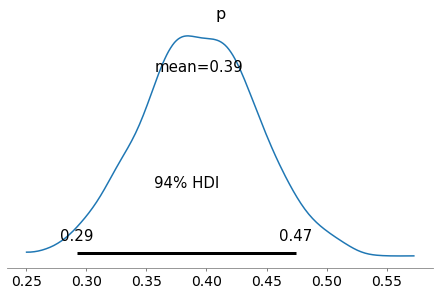

In [6]:
Y = spell_length(df_rain['1905'], 0)[1]

basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    p = pm.Beta('p', alpha=1, beta=1)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Geometric('Y_obs', p=1-p, observed=Y)
    
    # draw 500 posterior samples
    trace = pm.sample(500)

#pm.traceplot(trace);
pm.plot_posterior(trace);

pm.summary(trace)

#### Sample Snowfall Analysis

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 19 seconds.
C:\Users\Asif Rezwan\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\Asif Rezwan\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.353,0.067,0.232,0.484,0.002,0.002,879.0,879.0,874.0,1343.0,1.01


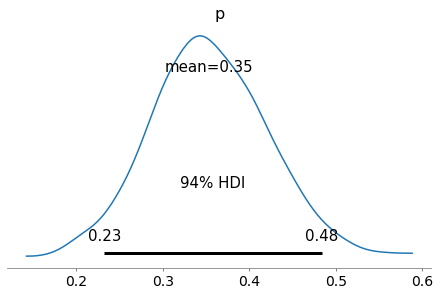

In [7]:
Y = spell_length(df_snow['1905'], 0)[1]

basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    p = pm.Beta('p', alpha=1, beta=1)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Geometric('Y_obs', p=1-p, observed=Y)
    
    # draw 500 posterior samples
    trace = pm.sample(500)

#pm.traceplot(trace);
pm.plot_posterior(trace);

pm.summary(trace)